In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
import pandas as pd
from keras import Sequential, layers, callbacks

df = pd.read_excel(r'data\gg.xlsx',  sheet_name=["Температура"])
df_holiday = pd.read_excel(r'data\gg.xlsx',  sheet_name=["Праздники"])
df_consumption = pd.read_excel(r'data\gg.xlsx',  sheet_name=['Потребление'])




In [5]:
df_holiday

{'Праздники':            Дата  id
 0    2010-01-01   3
 1    2010-01-02   3
 2    2010-01-03   3
 3    2010-01-04   3
 4    2010-01-05   3
 ...         ...  ..
 4013 2020-12-27   1
 4014 2020-12-28   0
 4015 2020-12-29   0
 4016 2020-12-30   0
 4017 2020-12-31   2
 
 [4018 rows x 2 columns]}

In [6]:
#df = df["Температура"].merge(df, on='Дата', how='inner')
cities = []
for i in range(63):
  df_i = df['Температура'][['Дата',i]]
  df_i = df_i.merge(df_holiday['Праздники'][['Дата','id']], on='Дата', how='inner')
  df_i = df_i.merge(df_consumption['Потребление'][['Дата',i]], on='Дата', how='inner')
  df_i.rename(columns={f'{i}_x':'Температура',f'{i}_y':'Потребление'}, inplace=True)
  cities.append(df_i)


In [7]:
cities[0]

,Дата,Температура,id,Потребление
0,2010-01-01,7.0,3,30.972282
1,2010-01-02,10.0,3,29.846362
2,2010-01-03,6.0,3,36.359652
3,2010-01-04,-1.0,3,41.859071
4,2010-01-05,-6.0,3,43.567304
...,...,...,...,...
4013,2020-12-27,6.0,1,39.037059
4014,2020-12-28,2.0,0,39.631884
4015,2020-12-29,4.0,0,38.135933
4016,2020-12-30,7.0,0,36.871494


In [8]:
features_considered = ['Температура', 'id','Потребление']

In [ ]:
features = cities[2][features_considered]
features.index = cities[0]['Дата']
features.head()

,Температура,id,Потребление
Дата,,,
2010-01-01,-18.0,3,71.062864
2010-01-02,-22.0,3,69.128023
2010-01-03,-29.0,3,72.273320
2010-01-04,-32.0,3,74.577852
2010-01-05,-29.0,3,77.448734


array([<Axes: xlabel='Дата'>, <Axes: xlabel='Дата'>,
       <Axes: xlabel='Дата'>], dtype=object)

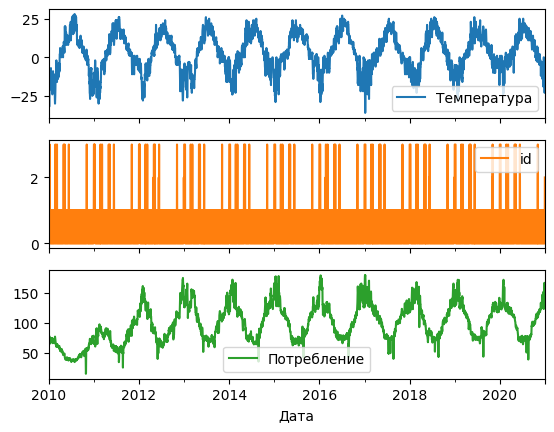

In [ ]:
features.plot(subplots=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler_target = MinMaxScaler()
features[['Температура', 'id']] = scaler.fit_transform(features[['Температура', 'id']])
features[['Потребление']] = scaler_target.fit_transform(features[['Потребление']])


<ipython-input-63-00b1dd7e28e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[['Температура', 'id']] = scaler.fit_transform(features[['Температура', 'id']])
<ipython-input-63-00b1dd7e28e6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[['Потребление']] = scaler_target.fit_transform(features[['Потребление']])


In [ ]:

TRAIN_SPLIT = 3218
dataset = features.values


In [ ]:
dataset

array([[0.28125   , 1.        , 0.34216181],
       [0.21875   , 1.        , 0.33048163],
       [0.109375  , 1.        , 0.34946905],
       ...,
       [0.203125  , 0.        , 0.92043884],
       [0.25      , 0.        , 0.90331901],
       [0.4375    , 0.66666667, 0.77765383]])

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
future_target = 5
past_history = 52
STEP = 1
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (52, 3)

 Target temperature to predict : (5,)


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 400
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 2]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

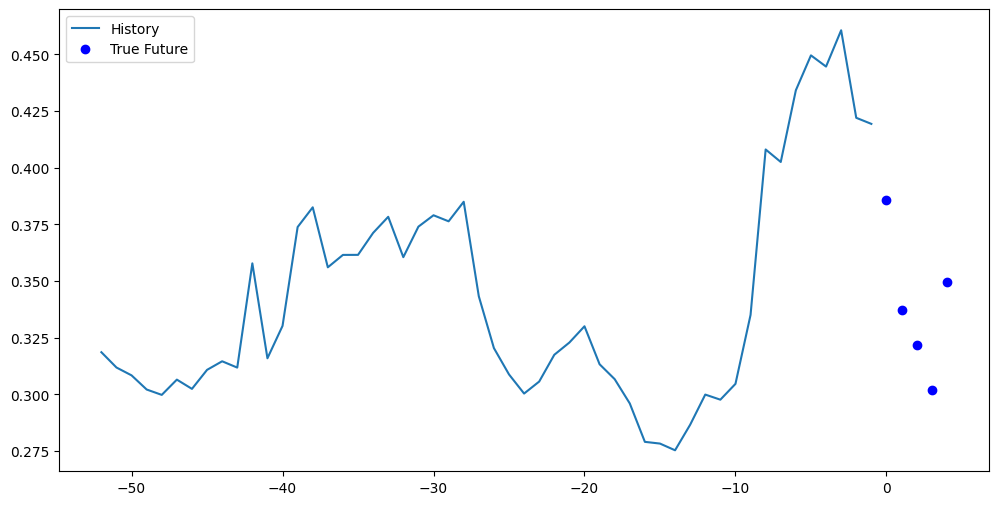

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5))
optimizer = keras.optimizers.Adam(learning_rate=0.001)


multi_step_model.compile(optimizer=optimizer, loss='mse')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 16ms/step
(256, 5)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 50
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # minimium amount of change to count as an improvement
    patience=5,  # how many epochs to wait before stopping
    restore_best_weights=True,
)
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          callbacks=[early_stopping],
                                          validation_steps=50)

Epoch 1/50
200/200 [==============================] - 21s 88ms/step - loss: 0.0236 - val_loss: 0.0049
Epoch 2/50
200/200 [==============================] - 17s 84ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 3/50
200/200 [==============================] - 17s 86ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 4/50
200/200 [==============================] - 17s 86ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 5/50
200/200 [==============================] - 18s 91ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 6/50
200/200 [==============================] - 19s 93ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 7/50
200/200 [==============================] - 17s 86ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/50
200/200 [==============================] - 17s 86ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/50
200/200 [==============================] - 17s 86ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 10/50
200/200 [==============================] - 18s 92ms/step - loss: 0.002

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

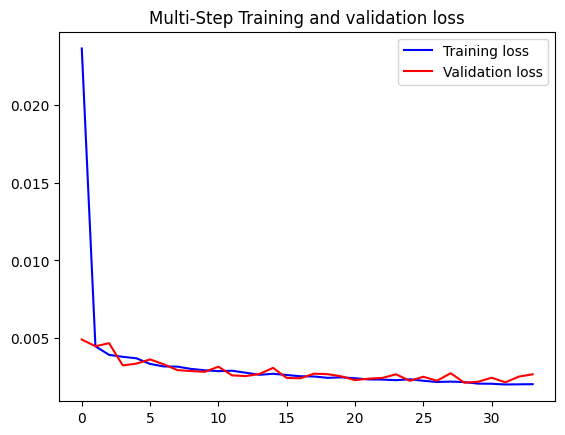

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 [==============================] - 0s 14ms/step
[0.7605201  0.7582316  0.75420415 0.7652536  0.76216066]
8/8 [==============================] - 0s 11ms/step


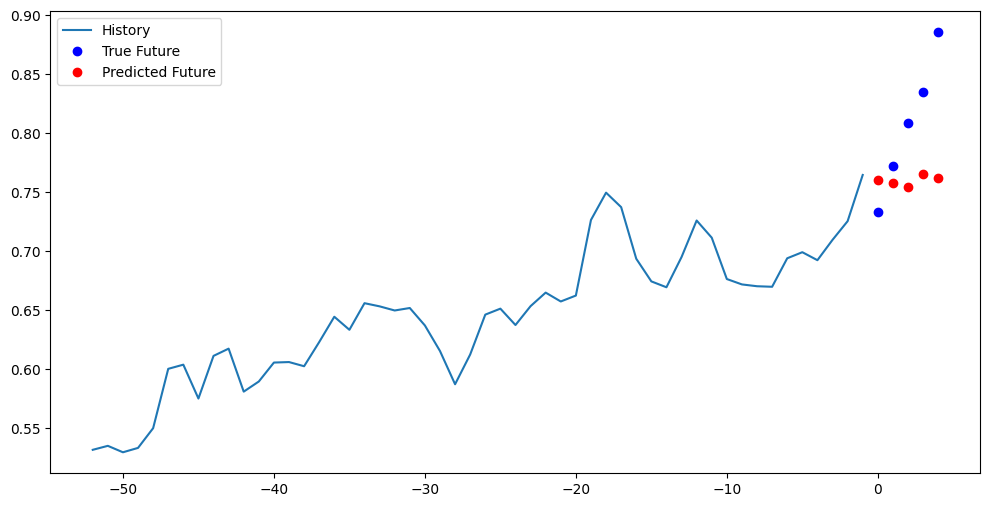

8/8 [==============================] - 0s 12ms/step
[0.41536057 0.40810272 0.40568775 0.41766158 0.41553187]
8/8 [==============================] - 0s 10ms/step


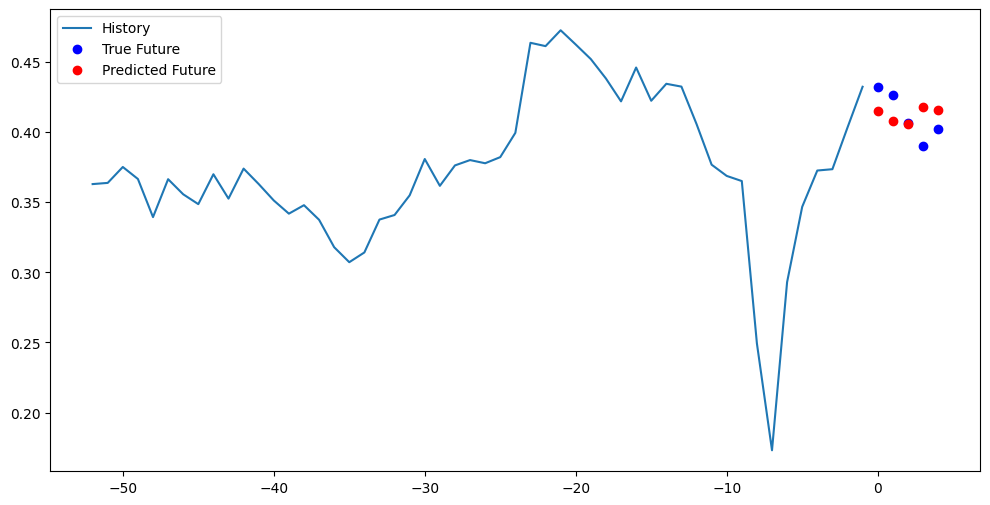

8/8 [==============================] - 1s 10ms/step
[0.47492215 0.47383073 0.4659486  0.47134715 0.4656467 ]
8/8 [==============================] - 0s 11ms/step


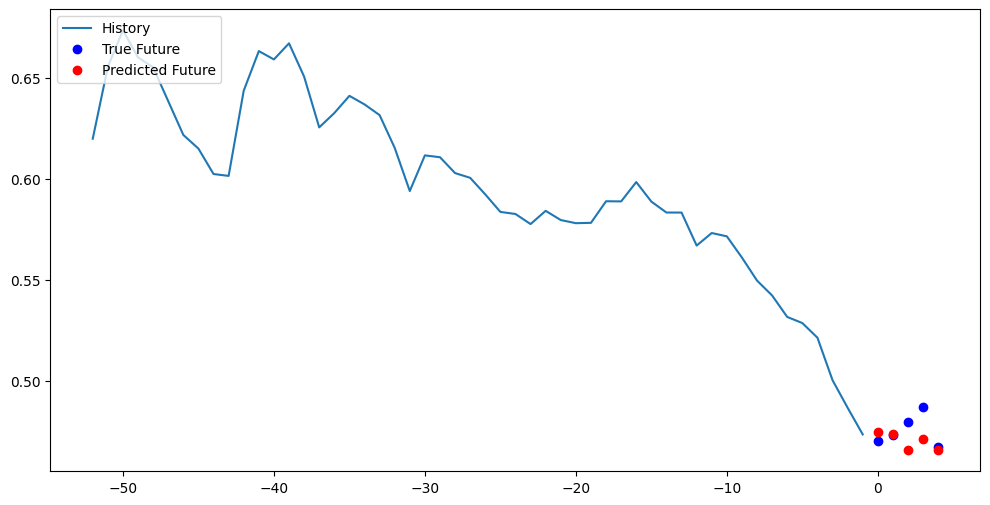

In [ ]:
for x, y in val_data_multi.take(3):
  print(multi_step_model.predict(x)[0])
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
print(val_data_multi)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 52, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [ ]:
val_data_multi_no_repeat = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi)).batch(BATCH_SIZE)
steps = len(list(val_data_multi_no_repeat))
predictions = multi_step_model.predict(val_data_multi, steps=steps)


3/3 [==============================] - 1s 31ms/step


In [ ]:
print(scaler_target.inverse_transform(predictions[0].reshape(-1, 1)))
print(scaler_target.inverse_transform(y_val_multi[0].reshape(-1, 1)))


[[140.3646 ]
 [139.9855 ]
 [139.31834]
 [141.14871]
 [140.63635]]
[[135.78350977]
 [142.27076326]
 [148.33168383]
 [152.73120043]
 [161.09579187]]


In [ ]:
from sklearn.metrics import mean_squared_error
mse_value = 0
for i in range(len(predictions)):
  mse_value += mean_squared_error(scaler_target.inverse_transform(y_val_multi[i].reshape(-1, 1)), scaler_target.inverse_transform(predictions[i].reshape(-1, 1)))


In [ ]:
print(mse_value/len(predictions))

58.26574256730568


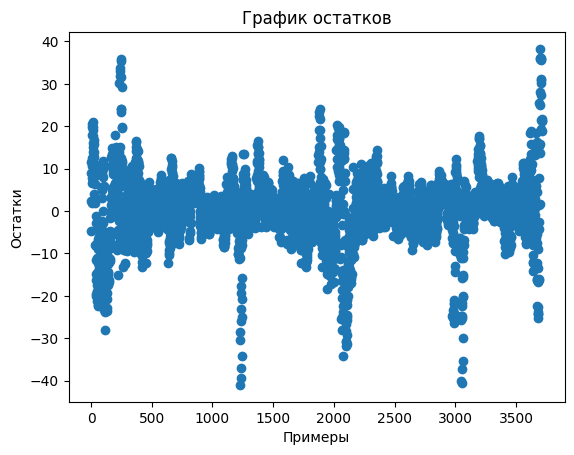

In [ ]:
# 1. Вычислить остатки
residuals = scaler_target.inverse_transform(y_val_multi.reshape(-1, 1)) - scaler_target.inverse_transform(predictions.reshape(-1, 1))

# 2. Построить график остатков
import matplotlib.pyplot as plt
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Примеры')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()
